### Data Analysis

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
cancer = pd.read_csv("clinical.tsv", sep='\t')
cancer = cancer.replace("'--", np.nan)
cancer = cancer.dropna(axis = 1, how = 'all')
cancer = cancer.drop(cancer.columns.difference(['case_submitter_id','age_at_index','days_to_death','gender','race','vital_status','year_of_birth','year_of_death','age_at_diagnosis','ajcc_pathologic_stage','icd_10_code','primary_diagnosis','prior_malignancy','prior_treatment','site_of_resection_or_biopsy','synchronous_malignancy','tissue_or_organ_of_origin','year_of_diagnosis','treatment_type']), 1)
initial_count_of_lines = cancer.shape[0]
cancer = cancer.dropna()
print("Number of deleted lines:", initial_count_of_lines-cancer.shape[0])
cancer = cancer.replace(['Not Reported','not reported'],np.nan).dropna(axis=0, how='any')
cancer = cancer.drop_duplicates(['case_submitter_id'], keep='first')
cancer.set_index("case_submitter_id", inplace=True)
print(cancer.shape)

Silinen satır sayısı: 16402
(1027, 18)


C:\Users\Dell\AppData\Local\Temp\ipykernel_10092\3133128390.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cancer = cancer.drop(cancer.columns.difference(['case_submitter_id','age_at_index','days_to_death','gender','race','vital_status','year_of_birth','year_of_death','age_at_diagnosis','ajcc_pathologic_stage','icd_10_code','primary_diagnosis','prior_malignancy','prior_treatment','site_of_resection_or_biopsy','synchronous_malignancy','tissue_or_organ_of_origin','year_of_diagnosis','treatment_type']), 1)


<Axes: ylabel='primary_diagnosis'>

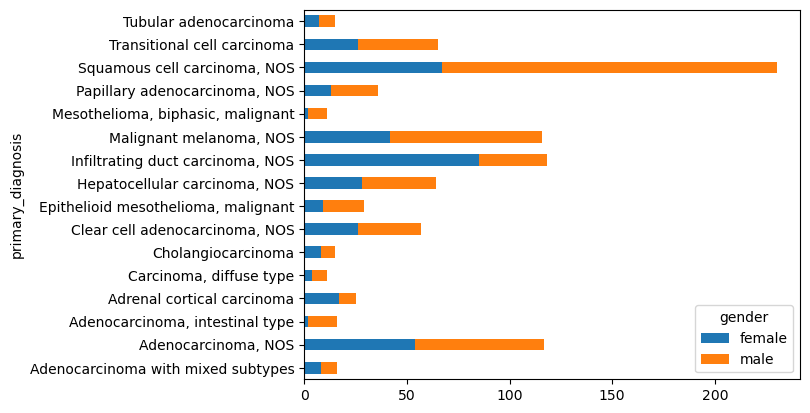

In [28]:
temp = cancer.groupby([cancer["primary_diagnosis"], cancer["gender"]]).size()
temp2 = temp.unstack().fillna(0).astype(temp.dtype)
temp2 = temp2[temp2["female"]+temp2["male"]>=10]
temp2.plot.barh(stacked=True)

primary_diagnosis
Squamous cell carcinoma, NOS                                 230
Infiltrating duct carcinoma, NOS                             118
Adenocarcinoma, NOS                                          117
Malignant melanoma, NOS                                      116
Transitional cell carcinoma                                   65
Hepatocellular carcinoma, NOS                                 64
Clear cell adenocarcinoma, NOS                                57
Papillary adenocarcinoma, NOS                                 36
Epithelioid mesothelioma, malignant                           29
Adrenal cortical carcinoma                                    25
Adenocarcinoma with mixed subtypes                            16
Adenocarcinoma, intestinal type                               16
Tubular adenocarcinoma                                        15
Cholangiocarcinoma                                            15
Mesothelioma, biphasic, malignant                             11
Carcino

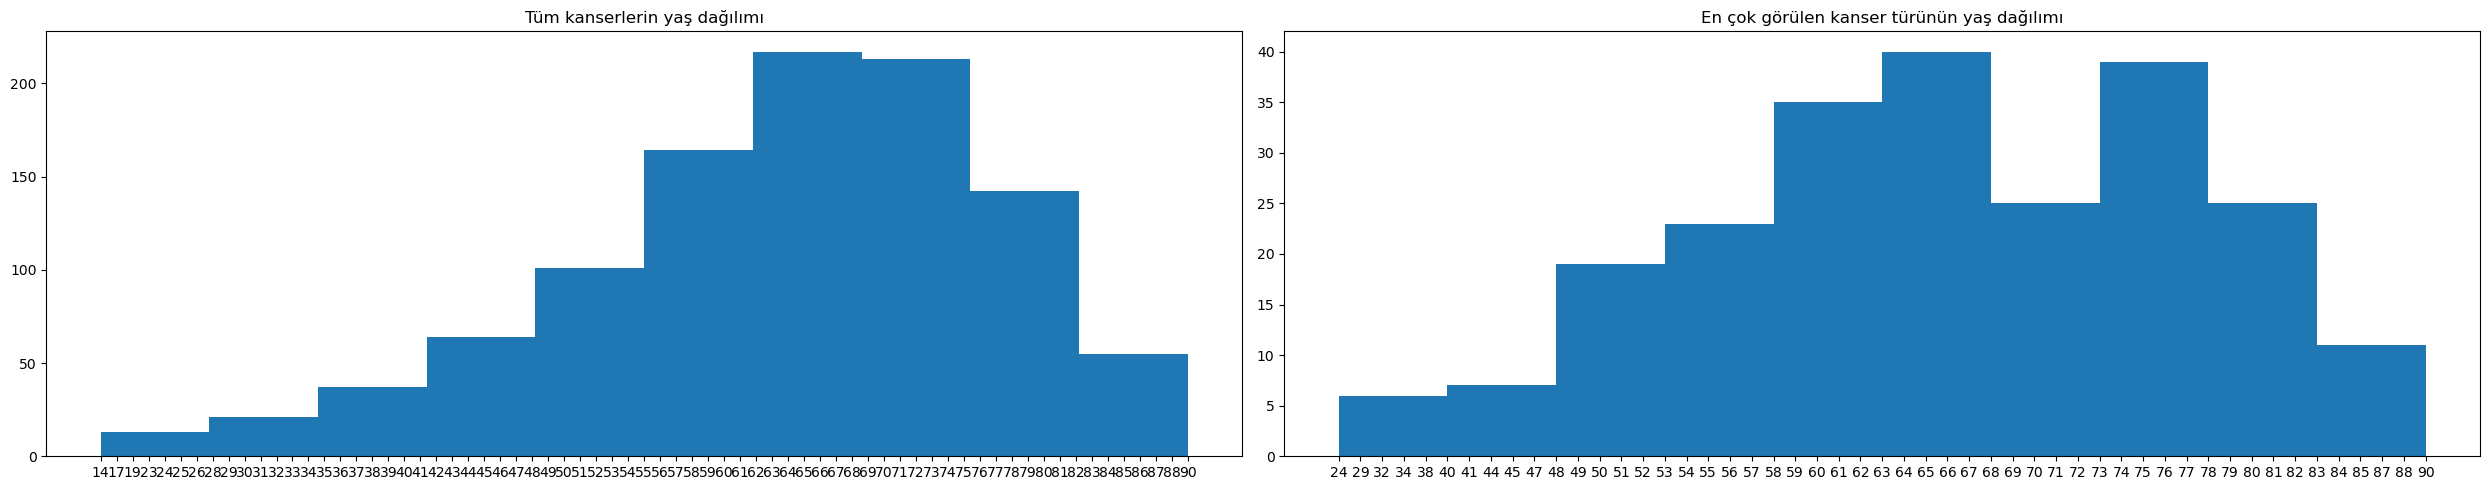

In [29]:
sorted = cancer.groupby(["primary_diagnosis"]).size().sort_values(ascending=False)
print(sorted)
most_common_disease = sorted.index[0]
temp = cancer.loc[cancer["primary_diagnosis"] == most_common_disease]
graph = plt.figure(figsize=(25,5))
graph1 = graph.add_subplot(1,2,1)
plt.hist(cancer["age_at_index"].sort_values().astype(str))
graph1.set_title("Age distribution of all types of cancer")
graph2 = graph.add_subplot(1,2,2)
plt.hist(temp["age_at_index"].sort_values().astype(str))
graph2.set_title("Age distribution of the most common cancer type")
graph.tight_layout()

In [30]:
cancer.groupby("primary_diagnosis")["days_to_death"].apply(lambda x : x.astype(int).mean()).sort_values(ascending=[False]).index[0]

'Amelanotic melanoma'

[]

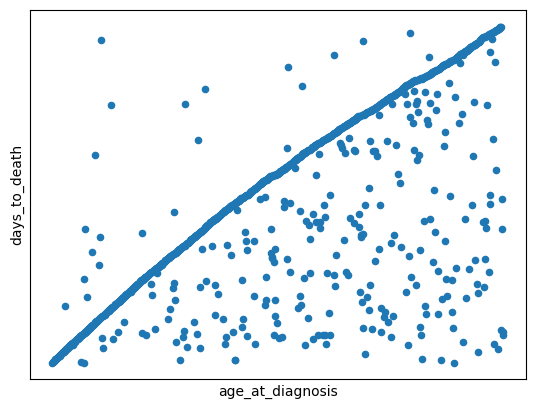

In [31]:
scatter = cancer.plot.scatter(x="age_at_diagnosis", y="days_to_death")
scatter.set_xticks([])
scatter.set_yticks([])

In [32]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
exposure = pd.read_csv("exposure.tsv", sep='\t')
exposure = exposure.set_index('case_submitter_id')
exposure = exposure.replace("'--", np.nan)
exposure = exposure.replace(["'--", "Not Reported"], np.nan)
exposure = exposure.dropna(axis = 1, how = 'all')
exposure = exposure.dropna()
print(exposure.shape)
cancer_exposure = pd.merge(cancer, exposure, how='inner', on = 'case_submitter_id')

(136, 6)


<Axes: >

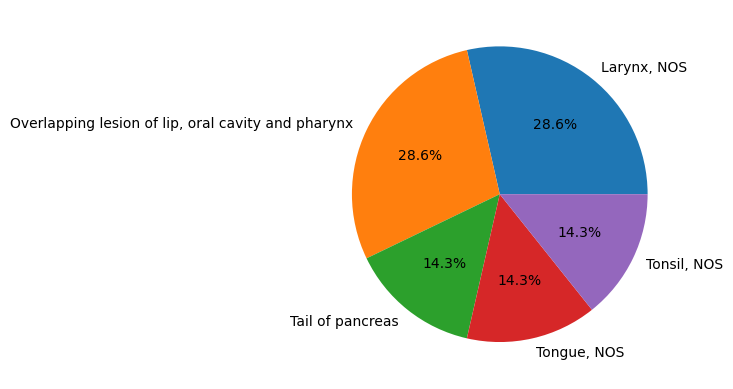

In [33]:
cancer_exposure = cancer_exposure[cancer_exposure['cigarettes_per_day'].astype(float) > 3]
cancer_exposure = cancer_exposure[cancer_exposure['alcohol_history'] == 'Yes']
cancer_exposure.groupby('tissue_or_organ_of_origin').size().plot(kind='pie',autopct='%1.1f%%',ylabel='')

### Machine Learning

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_validate

cancer = cancer.replace(['Stage IS'],np.nan).dropna(axis = 0, how = 'any')
x = cancer.loc[:,["age_at_diagnosis","ajcc_pathologic_stage","prior_malignancy","synchronous_malignancy","tissue_or_organ_of_origin","treatment_type"]]
x["treatment_type"].replace(to_replace=["Pharmaceutical Therapy, NOS", "Radiation Therapy, NOS"], value=[1,2], inplace=True)
x["prior_malignancy"].replace(to_replace=["no", "yes"], value=[0,1], inplace=True)
x["synchronous_malignancy"].replace(to_replace=["No", "Not Reported", "Yes"], value=[0,0,1], inplace=True)
x["age_at_diagnosis"] = x["age_at_diagnosis"].astype(int)
x["age_at_diagnosis"] = (x["age_at_diagnosis"] - np.mean(x["age_at_diagnosis"], axis=0)) / np.std(x["age_at_diagnosis"], axis=0)
x["ajcc_pathologic_stage"].replace(to_replace=["Stage 0", "Stage I", "Stage IA", "Stage IB", "Stage II", "Stage IIA", "Stage IIB", "Stage IIC", "Stage III", "Stage IIIA", "Stage IIIB", "Stage IIIC", "Stage IV", "Stage IVA", "Stage IVB", "Stage IVC", "Stage X"], value=[0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0], inplace=True)
x2 = x.copy(deep=True)
x = pd.get_dummies(x[["age_at_diagnosis","ajcc_pathologic_stage","prior_malignancy","synchronous_malignancy","tissue_or_organ_of_origin","treatment_type"]], columns=["tissue_or_organ_of_origin"])
y = cancer["days_to_death"]
metrics = ["neg_mean_squared_error", "neg_median_absolute_error", "r2"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
regression1 = LinearRegression()
regression1.fit(X_train, y_train)
cross_validation = cross_validate(regression1, X_train, y_train, scoring=metrics, cv=5)
print("Linear regression-1:")
print("MSE:", cross_validation['test_neg_mean_squared_error'].mean()*-1)
print("MAE:", cross_validation['test_neg_median_absolute_error'].mean()*-1)
print("R2:", cross_validation["test_r2"].mean())

#######################################################################################################################

column_list = ['Mouth','Pancreas','Lung','Stomach','Kidney','Breast','Skin','Bladder','Liver','Larynx','Eye','Colon','Testis'] 

for i in range(len(column_list)):
    x2[column_list[i]] = 0

for i in range(len(x.index)):
    name = x2.iat[i,4]
    if name in ['Tongue, NOS','Overlapping lesion of lip, oral cavity and pharynx','Floor of mouth, NOS','Mouth, NOS','Cheek mucosa','Base of tongue, NOS','Hard palate','Lower gum','Upper Gum']:
        x2.iat[i,6] = 1
    elif name in ['Head of pancreas','Body of pancreas','Pancreas, NOS','Tail of pancreas']:
        x2.iat[i,7] = 1
    elif name in ['Lower lobe, lung','Middle lobe, lung','Upper lobe, lung','Overlapping lesion of lung','Pleura, NOS','Main bronchus','Lung, NOS']:
        x2.iat[i,8] = 1    
    elif name in ['Gastric antrum','Body of stomach','Cardia, NOS','Fundus of stomach','Stomach, NOS','Lower third of esophagus','Middle third of esophagus','Esophagus, NOS']:
        x2.iat[i,9] = 1
    elif name in ['Kidney, NOS','Cortex of adrenal gland']:
        x2.iat[i,10] = 1
    elif name in ['Breast, NOS','Overlapping lesion of breast','Upper-outer quadrant of breast','Lower-inner quadrant of breast']:
        x2.iat[i,11] = 1
    elif name in ['Skin, NOS']:
        x2.iat[i,12] = 1
    elif name in ['Bladder, NOS','Trigone of bladder','Posterior wall of bladder','Bladder neck','Lateral wall of bladder','Dome of bladder','Anterior wall of bladder']:
        x2.iat[i,13] = 1
    elif name in ['Intrahepatic bile duct','Extrahepatic bile duct','Liver']:
        x2.iat[i,14] = 1
    elif name in ['Larynx','Hypopharynx, NOS','Tonsil, NOS','Thyroid gland']:
        x2.iat[i,15] = 1
    elif name in ['Choroid','Overlapping lesion of eye and adnexa']:
        x2.iat[i,16] = 1
    elif name in ['Sigmoid colon','Transverse colon','Descending colon','Rectosigmoid junction','Ascending colon','Rectum, NOS','Splenic flexure of colon','Cecum']:
        x2.iat[i,17] = 1
    elif name in ['Testis, NOS']:
        x2.iat[i,18] = 1
x2 = x2.drop(columns=['tissue_or_organ_of_origin'], axis=1)

##############################################################################################################################

print("\nLinear regression-2:")
X_train, X_test, y_train, y_test = train_test_split(x2, y, test_size=0.2, random_state=42)
regression2 = LinearRegression()
regression2.fit(X_train, y_train)
cross_validation = cross_validate(regression2, X_train, y_train, scoring=metrics, cv=5)
print("MSE:", cross_validation['test_neg_mean_squared_error'].mean()*-1)
print("MAE:", cross_validation['test_neg_median_absolute_error'].mean()*-1)
print("R2:", cross_validation["test_r2"].mean())

Linear regression-1:
MSE: 1.0109077167384342e+28
MAE: 441.28125
R2: -8.392159030000543e+21

Linear regression-2:
MSE: 757738.4246748922
MAE: 417.6420538664237
R2: 0.2081095465675702


In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score

cancer = cancer.replace(['Stage IS'],np.nan).dropna(axis = 0, how = 'any')
x = cancer.loc[:, ["age_at_diagnosis", "ajcc_pathologic_stage", "prior_malignancy", "prior_treatment", "synchronous_malignancy","tissue_or_organ_of_origin"]]
x["prior_malignancy"].replace(to_replace=["no", "yes"], value=[0,1], inplace=True)
x["prior_treatment"].replace(to_replace=["No", "Yes"], value=[0,1], inplace=True)
x["synchronous_malignancy"].replace(to_replace=["No", "Yes"], value=[0,1], inplace=True)
x["ajcc_pathologic_stage"].replace(to_replace=["Stage 0", "Stage I", "Stage IA", "Stage IB", "Stage II", "Stage IIA", "Stage IIB", "Stage IIC", "Stage III", "Stage IIIA", "Stage IIIB", "Stage IIIC", "Stage IV", "Stage IVA", "Stage IVB", "Stage IVC", "Stage X"], value=[0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0], inplace=True)
x["age_at_diagnosis"] = x["age_at_diagnosis"].astype(int)
x["age_at_diagnosis"] = (x["age_at_diagnosis"] - np.mean(x["age_at_diagnosis"], axis=0)) / np.std(x["age_at_diagnosis"], axis=0)
y = cancer["treatment_type"]
metrics = ['accuracy', 'roc_auc']

#######################################################################################################################
column_list = ['Mouth','Pancreas','Lung','Stomach','Kidney','Breast','Skin','Bladder','Liver','Larynx','Eye','Colon','Testis'] 

for i in range(len(column_list)):
    x[column_list[i]] = 0

for i in range(len(x.index)):
    name = x.iat[i,5]
    if name in ['Tongue, NOS','Overlapping lesion of lip, oral cavity and pharynx','Floor of mouth, NOS','Mouth, NOS','Cheek mucosa','Base of tongue, NOS','Hard palate','Lower gum','Upper Gum']:
        x.iat[i,6] = 1
    elif name in ['Head of pancreas','Body of pancreas','Pancreas, NOS','Tail of pancreas']:
        x.iat[i,7] = 1
    elif name in ['Lower lobe, lung','Middle lobe, lung','Upper lobe, lung','Overlapping lesion of lung','Pleura, NOS','Main bronchus','Lung, NOS']:
        x.iat[i,8] = 1    
    elif name in ['Gastric antrum','Body of stomach','Cardia, NOS','Fundus of stomach','Stomach, NOS','Lower third of esophagus','Middle third of esophagus','Esophagus, NOS']:
        x.iat[i,9] = 1
    elif name in ['Kidney, NOS','Cortex of adrenal gland']:
        x.iat[i,10] = 1
    elif name in ['Breast, NOS','Overlapping lesion of breast','Upper-outer quadrant of breast','Lower-inner quadrant of breast']:
        x.iat[i,11] = 1
    elif name in ['Skin, NOS']:
        x.iat[i,12] = 1
    elif name in ['Bladder, NOS','Trigone of bladder','Posterior wall of bladder','Bladder neck','Lateral wall of bladder','Dome of bladder','Anterior wall of bladder']:
        x.iat[i,13] = 1
    elif name in ['Intrahepatic bile duct','Extrahepatic bile duct','Liver']:
        x.iat[i,14] = 1
    elif name in ['Larynx','Hypopharynx, NOS','Tonsil, NOS','Thyroid gland']:
        x.iat[i,15] = 1
    elif name in ['Choroid','Overlapping lesion of eye and adnexa']:
        x.iat[i,16] = 1
    elif name in ['Sigmoid colon','Transverse colon','Descending colon','Rectosigmoid junction','Ascending colon','Rectum, NOS','Splenic flexure of colon','Cecum']:
        x.iat[i,17] = 1
    elif name in ['Testis, NOS']:
        x.iat[i,18] = 1
x2 = x.copy(deep=True)
x = x.drop(columns=['tissue_or_organ_of_origin'], axis=1)         

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

###################################################################################################### Decision Tree

dt_param_grid = {'max_depth':[2, 4, 8]}
decision_tree = DecisionTreeClassifier()
grid_dt = GridSearchCV(decision_tree,dt_param_grid)
grid_dt.fit(X_train, y_train)
cross_validation = cross_validate(decision_tree, x, y, cv=5, scoring=metrics)
print("Decision Tree accuracy:", cross_validation['test_accuracy'].mean())
print("Decision Tree AUC:", cross_validation['test_roc_auc'].mean())

###################################################################################################### Random Forest

rf_param_grid = {'n_estimators': [16, 18, 20], 'max_depth':[2, 5, 8]}
random_forest = RandomForestClassifier()
grid_rf = GridSearchCV(random_forest, rf_param_grid)
grid_rf.fit(X_train, y_train)
cross_validation = cross_validate(random_forest, x, y, cv=5, scoring=metrics)
print("Random Forest accuracy:", cross_validation['test_accuracy'].mean())
print("Random Forest AUC:", cross_validation['test_roc_auc'].mean())

###################################################################################################### Logistic Regression-1

lr_param_grid = {'C': [0.01,10], 'penalty': ['l2'], 'solver': ['liblinear']}
logistic_reg = LogisticRegression(random_state=0)
grid_lr = GridSearchCV(logistic_reg, lr_param_grid)
grid_lr.fit(x, y)
cross_validation = cross_validate(logistic_reg, x, y, cv=5, scoring=metrics)
print("Logistic Regression-1 accuracy:", cross_validation['test_accuracy'].mean())
print("Logistic Regression-1 AUC:", cross_validation['test_roc_auc'].mean())

###################################################################################################### Logistic Regression-2

x2 = x2.drop(columns=['tissue_or_organ_of_origin',"ajcc_pathologic_stage"], axis=1)
logistic_reg2 = LogisticRegression(random_state=0)
grid_lr2 = GridSearchCV(logistic_reg, lr_param_grid)
grid_lr2.fit(x2, y)
cross_validation = cross_validate(logistic_reg2, x2, y, cv=5, scoring=metrics)
print("Logistic Regression-2 accuracy:", cross_validation['test_accuracy'].mean())
print("Logistic Regression-2 AUC:", cross_validation['test_roc_auc'].mean())

Decision Tree accuracy: 0.4805209566658773
Decision Tree AUC: 0.4799826856999279
Random Forest accuracy: 0.5029741889651906
Random Forest AUC: 0.5039049314148126
Logistic Regression-1 accuracy: 0.5194837793038125
Logistic Regression-1 AUC: 0.5219750720184702
Logistic Regression-2 accuracy: 0.5077717262609519
Logistic Regression-2 AUC: 0.5182263201718845
